# Perspective change 

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle

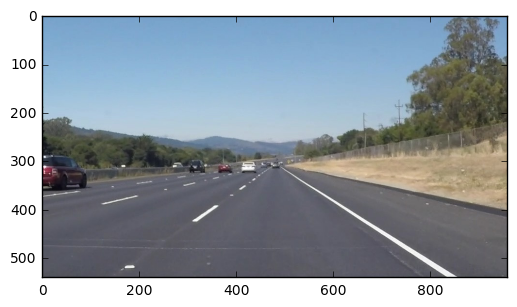

In [3]:
img = mpimg.imread('./test_images/solidWhiteRight.jpg')
# img = mpimg.imread('./test_images/test3.jpg')
plt.imshow(img)

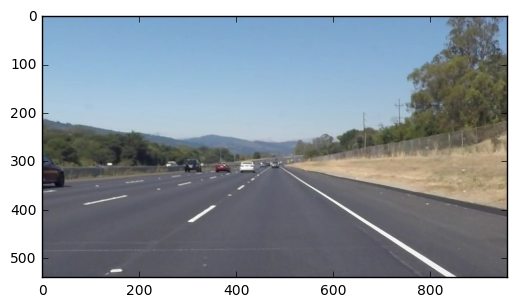

In [4]:
#Undistort the image .. because
camera_cal = pickle.load( open( "camera_cal.p", "rb" ) )
ret = camera_cal[0]
mtx = camera_cal[1]
dist = camera_cal[2]
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

In [5]:
def pipeline(img):
    
    sx_thresh=(30,75)
    s_thresh=(170, 230)
    u_thresh=(0,80)
    z_thresh=(240,255)

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv).astype(np.float)
    xyz = cv2.cvtColor(img, cv2.COLOR_BGR2XYZ).astype(np.float)

    sobel_kernel = 5

    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F,1,0,ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel=np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # sobelxx = cv2.Sobel(abs_sobelx, cv2.CV_64F,1,0,ksize = 3)
    # abs_sobelxx = np.absolute(sobelxx)

    #Threshold sx gradient
    sx_binary = np.zeros_like(hls[:,:,2])
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] =1

    #Threshold s_color channel
    s_binary = np.zeros_like(hls[:,:,2])
    s_binary[(hls[:,:,2] >= s_thresh[0]) & (hls[:,:,2] <= s_thresh[1])] = 1

    #Threshold u_color channel
    u_binary = np.zeros_like(luv[:,:,1])
    u_binary[(luv[:,:,1] >= u_thresh[0]) & (luv[:,:,1] <= u_thresh[1])] = 1

    #Threshold z_color channel
    z_binary = np.zeros_like(xyz[:,:,2])
    z_binary[(xyz[:,:,2] >= z_thresh[0]) & (xyz[:,:,2] <= z_thresh[1])] = 1


    uz_binary = np.zeros_like(xyz[:,:,2])
    uz_binary[(u_binary ==1) | (z_binary==1)]=1
    #Stach each channel
    color_binary = np.dstack((uz_binary, sx_binary, s_binary))
    
    #OR each channel
    OR_binary = np.zeros_like(xyz[:,:,2])
    OR_binary[(uz_binary ==1) | (sx_binary ==1) | (s_binary ==1)] =1
    return OR_binary

(0.1640625, 0.9444444444444444) (0.42578125, 0.6527777777777778) (0.578125, 0.6527777777777778) (0.859375, 0.9444444444444444)


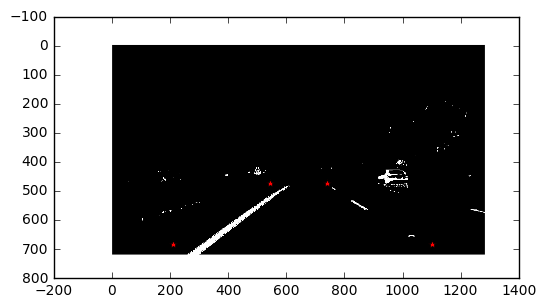

In [7]:
# test_img2 = mpimg.imread('./test_images/solidWhiteRight.jpg')
test_img2 = mpimg.imread('./test_images/test3.jpg')
dst_img2 = cv2.undistort(test_img2, mtx, dist, None, mtx)
test_res2 = pipeline(dst_img2)
ym,xm = (np.shape(test_res2))
xref = 1280
yref = 720

#These points were generated from the solidWhiteRight file
#Assume these lines are straight and adjust the points until the perspective transform is straight
pt1s = (210.0/xref ,680/yref)
pt2s = (545.0/xref, 470/yref)
pt3s = (740.0/xref, 470/yref)
pt4s = (1100.0/xref, 680/yref)
print (pt1s, pt2s, pt3s, pt4s)

pt1 = (pt1s[0]*xm, pt1s[1]*ym)
pt2 = (pt2s[0]*xm, pt2s[1]*ym)
pt3 = (pt3s[0]*xm, pt3s[1]*ym)
pt4 = (pt4s[0]*xm, pt4s[1]*ym)


plt.imshow(test_res2,cmap="bone")
plt.plot(pt1[0],pt1[1],'r*')
plt.plot(pt2[0],pt2[1],'r*')
plt.plot(pt3[0],pt3[1],'r*')
plt.plot(pt4[0],pt4[1],'r*')

In [8]:
##Calibrate the perspective change

src = np.float32([pt1,pt2,pt3,pt4])

img_size = (np.shape(test_res2)[1],np.shape(test_res2)[0])
warp_img_size = (800,600)
offset = 100
dst = np.float32([[offset, warp_img_size[1]-offset],[offset, offset], [warp_img_size[0]-offset, offset], 
                                     [warp_img_size[0]-offset, warp_img_size[1]-offset]])

print(dst)
# dst = np.float32([[100,100],[img_size[0]-offset,300],[1100,300],[1100,680]])

[[ 100.  500.]
 [ 100.  100.]
 [ 700.  100.]
 [ 700.  500.]]


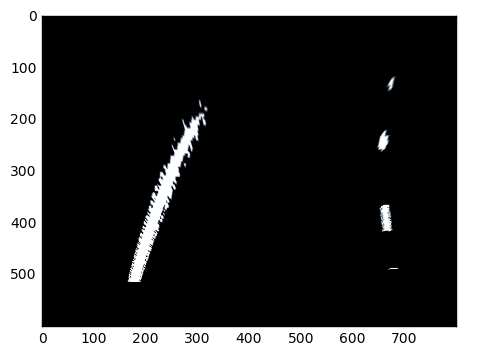

In [9]:
##This may be giving images upside-down

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(test_res2, M, warp_img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='bone')

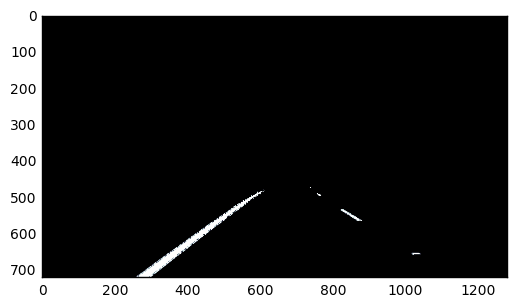

In [10]:
#Transform the mask back to make sure it works
inv_warped = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(inv_warped,cmap='bone')

In [25]:
## SAVE THE TF

pickle.dump((M, Minv), open( "M_Minv.p", "wb" ) )

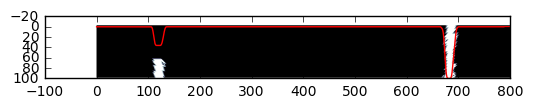

In [20]:
i=280
w=100
plt.imshow(warped[i:i+w,:],cmap='bone')
histogram = np.sum(warped[i:i+w,:], axis=0)
plt.plot(histogram,'r')